# Deep Learning
# Examen Agosto 2022

El examen comienza el jueves 11 de agosto y la ventana de entrega estará abierta hasta el domingo 28 de agosto a las 20:00hs. Toda comunicación con otros alumnos respecto del examen y la resolución de los ejercicios, queda estrictamente prohibida. Los exámenes serán comparados desde el punto de vista de la redacción, de los resultados y del código para determinar que el trabajo fue 100% individual y único. El examen es a libro abierto, pudiendo utilizar los contenidos vistos en clase y otra bibliografía. Todas las soluciones deben ser originales y si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (compartir a las siguientes direcciones: eesposito@optiwe.com y lelectronfou@gmail.com ) o un “link a un notebook en un github público” (tanto con los resultados, cómo el código y las explicaciones deben quedar guardados y visualizables en el correspondiente link).

# Ejercicio 1

1) Descargar el dataset desde el [siguiente link](https://drive.google.com/file/d/19SrZcnAWM0k2RGPeeul65wqycci1jS05/view?usp=sharing). Entrenar el modelo propuesto a continuación de este enunciado. El modelo está haciendo underfitting, overfitting o un fit correcto. ¿Por qué? Explicar el procedimiento realizado.

$y_{hat} = 𝑋^3𝑊_1 + 𝑋^2𝑊_2 + 𝑋𝑊_1 + 𝑏$


## Imports

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import r2_score
import sklearn.metrics as metrics

## Helper functions

In [ ]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
def create_mini_batches(X, y, batch_size):
    mini_batches = []
    data = np.hstack((X, y))
    np.random.shuffle(data)
    n_minibatches = data.shape[0] // batch_size
    i = 0

    for i in range(n_minibatches + 1):
        mini_batch = data[i * batch_size:(i + 1) * batch_size, :]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))

    if data.shape[0] % batch_size != 0:
        mini_batch = data[i * batch_size:data.shape[0]]
        X_mini = mini_batch[:, :-1]
        Y_mini = mini_batch[:, -1].reshape((-1, 1))
        mini_batches.append((X_mini, Y_mini))

    return mini_batches

In [ ]:
def add_dummies(df, col_name, prefix=None, drop_first=True):
    dummies = pd.get_dummies(df[col_name], drop_first=drop_first, prefix=prefix)
    # Borro la columna y agrego los dummies de esta al dataset
    df = df.drop(col_name, axis=1)
    df = df.join(dummies)
    return df


def one_hot(df, columns_dict):
    for col in columns_dict:
        df = add_dummies(df, col, prefix=columns_dict[col])
    return df

## Abriendo el dataset

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
dataset_path = "drive/MyDrive/CEIA/TPS/Deep Learning I/Examen/dataset_1.csv"
# dataset_path = "./dataset_1.csv"
dataset = pd.read_csv(dataset_path).rename(columns = {'# X':"X", "Y":"y"})
dataset.head()

,X,y
0,1.791979,4.952906
1,0.846885,1.424248
2,1.000300,0.454364
3,1.884188,6.681510
4,0.889089,1.211691


In [ ]:
X = dataset[["X"]]
X.head()

,X
0,1.791979
1,0.846885
2,1.000300
3,1.884188
4,0.889089


In [ ]:
y = dataset[["y"]]
y.head()

,y
0,4.952906
1,1.424248
2,0.454364
3,6.681510
4,1.211691


## Train-Test split para entrenar y validar el modelo

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, random_state=42)
print("Shape de X_train:", X_train.shape)
print("Shape de y_train:", y_train.shape)
print("Shape de X_test:", X_test.shape)
print("Shape de y_test:", y_test.shape)

Shape de X_train: (7000, 1)
Shape de y_train: (7000, 1)
Shape de X_test: (3000, 1)
Shape de y_test: (3000, 1)


## Red Neuronal con Mini Batch

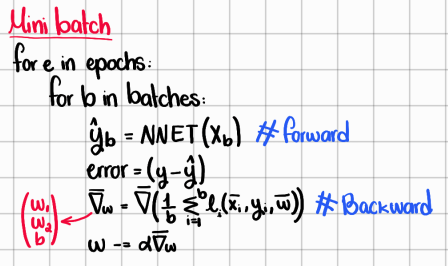

### Forward

El paso forward es la funcion dada en el enunciado:

$y_{hat} = 𝑋^3𝑊_1 + 𝑋^2𝑊_2 + 𝑋𝑊_1 + 𝑏$

### Backward

Para el paso backward (back propagation) calculo las derivadas con respecto de W1, W2 y el bias

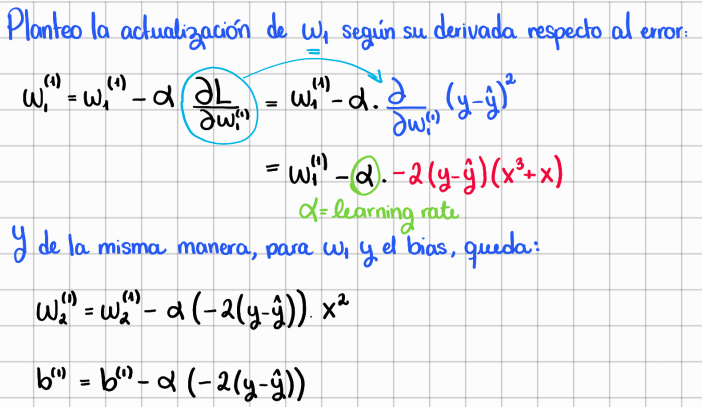

In [ ]:
class MiniBatch:

    def __init__(self):
        self.MSE = list()
        self.validation_MSE = list()
        self.batch_size = 0
        self.lr = 0

        # inicialización de pesos y del bias
        self.w1 = 0
        self.w2 = 0
        self.bias = 0

    def forward_propagation(self, X):
        x1, x2, x3 = X, X** 2, X ** 3
        return self.w1 * x3 + self.w2 * x2 + self.w1 * x1 + self.bias

    def back_propagation(self, X, error):
        x1, x2, x3 = X, X ** 2, X ** 3

        # calculando derivadas
        d_prediction = - 2 * error
        w1_loss = (d_prediction * (x3 + x1)).sum(axis=0)
        w2_loss = (d_prediction * x2).sum(axis=0)
        bias_loss = d_prediction.sum(axis=0)

        # update de los pesos
        self.w1 -= self.lr * w1_loss / self.batch_size
        self.w2 -= self.lr * w2_loss / self.batch_size
        self.bias -= self.lr * bias_loss / self.batch_size

    def train(self, X, y, X_test, y_test, n_epochs, lr, batch_size, verbose=False):
        self.batch_size = batch_size
        self.lr = lr

        for epoch in range(1, n_epochs+1):
            iteration_error, val_iter_error = 0, 0
            mini_batches = create_mini_batches(X, y, self.batch_size)
            val_batches = create_mini_batches(X_test, y_test, self.batch_size)

            for batch in mini_batches:
                X_batch, y_batch = batch

                # forward
                predictions = self.forward_propagation(X_batch)

                # error
                error = y_batch - predictions
                iteration_error += np.sum(error ** 2) / self.batch_size

                # backprop
                self.back_propagation(X_batch, error)

            self.MSE.append(iteration_error / n_epochs)

            for val_batch in val_batches:
                X_val_batch, y_val_batch = val_batch

                # forward
                predictions = self.forward_propagation(X_val_batch)

                # error
                error = y_val_batch - predictions
                val_iter_error += np.sum(error ** 2) / self.batch_size

            self.validation_MSE.append(val_iter_error / n_epochs)

            if verbose and epoch % 10 == 0:
                print("Epoch {}/{}".format(epoch, n_epochs))

        if verbose:
            print("TRAINING DONE!")

    def predict(self, input):
        predictions = self.forward_propagation(input)
        return predictions

## Entrenando el modelo

In [ ]:
mini_batch = MiniBatch()
mini_batch.train(X_train, y_train, X_test, y_test, n_epochs=1000, batch_size=32, lr=0.001, verbose=True)

Epoch 10/1000
Epoch 20/1000
Epoch 30/1000
Epoch 40/1000
Epoch 50/1000
Epoch 60/1000
Epoch 70/1000
Epoch 80/1000
Epoch 90/1000
Epoch 100/1000
Epoch 110/1000
Epoch 120/1000
Epoch 130/1000
Epoch 140/1000
Epoch 150/1000
Epoch 160/1000
Epoch 170/1000
Epoch 180/1000
Epoch 190/1000
Epoch 200/1000
Epoch 210/1000
Epoch 220/1000
Epoch 230/1000
Epoch 240/1000
Epoch 250/1000
Epoch 260/1000
Epoch 270/1000
Epoch 280/1000
Epoch 290/1000
Epoch 300/1000
Epoch 310/1000
Epoch 320/1000
Epoch 330/1000
Epoch 340/1000
Epoch 350/1000
Epoch 360/1000
Epoch 370/1000
Epoch 380/1000
Epoch 390/1000
Epoch 400/1000
Epoch 410/1000
Epoch 420/1000
Epoch 430/1000
Epoch 440/1000
Epoch 450/1000
Epoch 460/1000
Epoch 470/1000
Epoch 480/1000
Epoch 490/1000
Epoch 500/1000
Epoch 510/1000
Epoch 520/1000
Epoch 530/1000
Epoch 540/1000
Epoch 550/1000
Epoch 560/1000
Epoch 570/1000
Epoch 580/1000
Epoch 590/1000
Epoch 600/1000
Epoch 610/1000
Epoch 620/1000
Epoch 630/1000
Epoch 640/1000
Epoch 650/1000
Epoch 660/1000
Epoch 670/1000
Epoc

## MSE

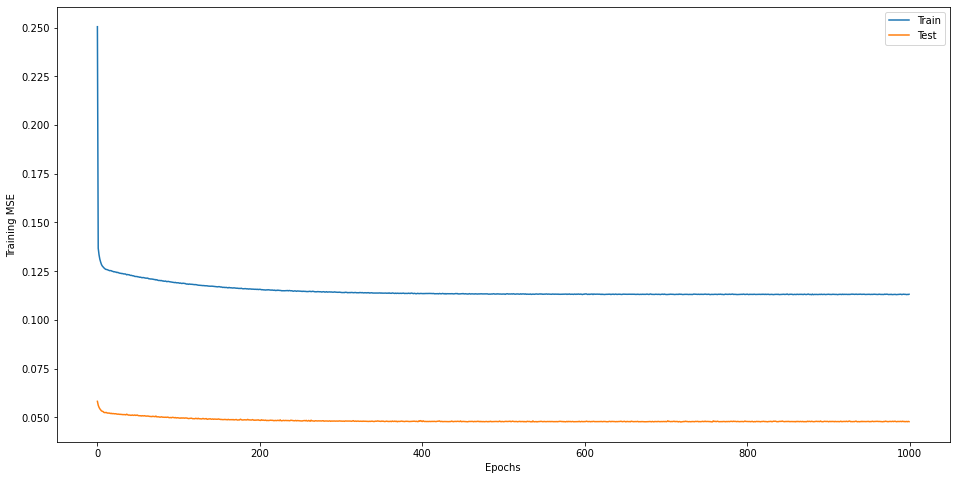

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(mini_batch.MSE, label='Train')
plt.plot(mini_batch.validation_MSE, label='Test')
plt.xlabel("Epochs")
plt.ylabel("Training MSE")
plt.legend()
plt.show()

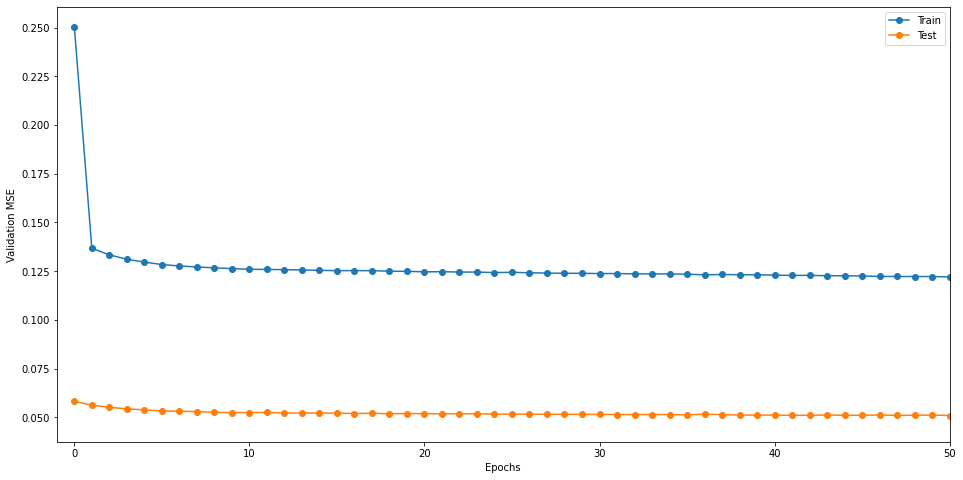

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(mini_batch.MSE, '-o', label='Train')
plt.plot(mini_batch.validation_MSE, '-o', label='Test')
plt.xlabel("Epochs")
plt.ylabel("Validation MSE")
plt.xlim([-1, 50])
plt.legend()
plt.show()

## Testing

In [ ]:
y_hat = mini_batch.predict(X_test)

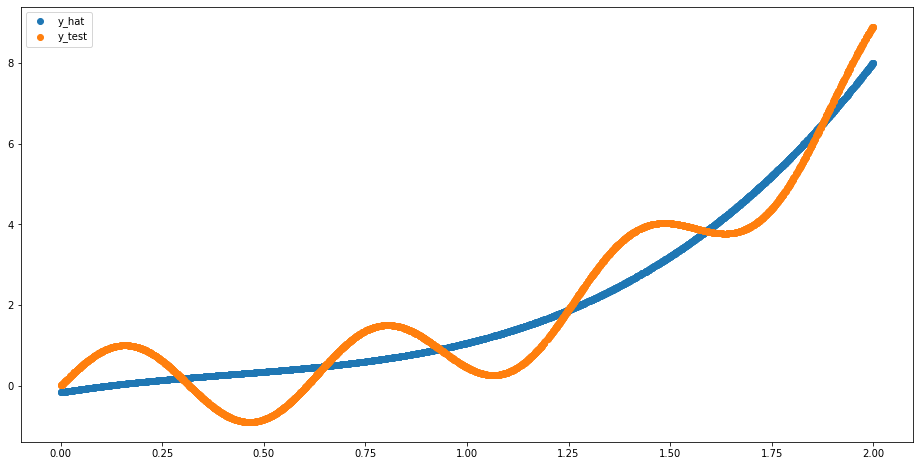

In [ ]:
plt.figure(figsize=(16,8))
plt.scatter(X_test, y_hat, label='y_hat')
plt.scatter(X_test, y_test, label='y_test')
plt.legend()
plt.show()

In [ ]:
print("Test R2 score: {}".format(r2_score(y_test, y_hat)))

Test R2 score: 0.9039541784692744


In [ ]:
y_train_hat = mini_batch.predict(X_train)
print("Train R2 score: {}".format(r2_score(y_train, y_train_hat)))

Train R2 score: 0.902985938507871


## ¿underfitting, overfitting o un fit correcto?

En este trabajo se entrenó un modelo con Mini Batch que asume que los datos son de la forma:
$y_{hat} = 𝑋^3𝑊_1 + 𝑋^2𝑊_2 + 𝑋𝑊_1 + 𝑏$ 

Al entrenar se fueron guardando los MSE del modelo contra el set de entrenamiento y contra el set de validación, como "Training Loss" y "Validation Loss" respectivamente.

Al ver el Validation Loss se ve que se mantiene relativamente baja y el Training Loss es mucho mayor.

Después se analizó la métrica de R2 y con un resultado de 0.90 podría decir que es un buen modelo... 

Pero cuando graficamos las predicciones del set de test se puede observar que el modelo tiene bias alto.

Tenemos bias alto porque hacemos una suposición muy fuerte sobre la forma de los datos. Al decir que cumple con $y_{hat} = 𝑋^3𝑊_1 + 𝑋^2𝑊_2 + 𝑋𝑊_1 + 𝑏$ le sacamos la flexibilidad y lo privamos de aprender la verdadera funcion que modela el set, esto significa que estamos haciendo un underfitting.


REFERENCIAS:

1. [Overfitting vs. Underfitting](http://www.pstu.ac.bd/files/materials/1566949131.pdf)
2. [How to check if your deep learning model is underfitting or overfitting](https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-check-if-your-deep-learning-model-is-underfitting-or-overfitting.md)
3. [Overfitting Machine Learning Models](https://machinelearningmastery.com/overfitting-machine-learning-models/)
4. [Determining when you are overfitting, underfitting or just right](https://forums.fast.ai/t/determining-when-you-are-overfitting-underfitting-or-just-right/7732/2)

# Ejercicio 2
2) Utilizando el mismo dataset que en el link anterior, diseñar una red neuronal que haga un overfitting sobre el dataset. ¿Cómo saben que la red neuronal está haciendo overfitting? Agregar regularización y encontrar los parámetros correctos para lograr un buen fit. Explicar el procedimiento realizado.

## Diseñando una red que haga overfitting

Para lograr un overfitting:
1. Necesito que la red tenga capacidad suficiente, es por esto que le agrego 5 capas capas lineales.
2. No voy a utilizar regularización
3. Entreno la red por muchos epochs

REFERENCIAS:
1. [How do I intentionally design an overfitting neural network](https://stats.stackexchange.com/questions/474738/how-do-i-intentionally-design-an-overfitting-neural-network)

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [ ]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [ ]:
train = MyDataset(X_train, y_train)
len(train)

7000

In [ ]:
valid = MyDataset(X_test, y_test)
len(valid)

3000

In [ ]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=64, shuffle=True)

In [ ]:
class NNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=50, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=50, out_features=100, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=100, out_features=200, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.linear_4 = torch.nn.Linear(in_features=200, out_features=100, bias=True)
        self.relu_4 = torch.nn.ReLU()
        self.linear_5 = torch.nn.Linear(in_features=100, out_features=75, bias=True)
        self.relu_5 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=75, out_features=1, bias=True)

    def forward(self, x): 
        x = self.linear_1(x) 
        x = self.relu_1(x) 
        x = self.linear_2(x) 
        x = self.relu_2(x) 
        x = self.linear_3(x)
        x = self.relu_3(x)
        x = self.linear_4(x)
        x = self.relu_4(x)
        x = self.linear_5(x)
        x = self.relu_5(x)
        x = self.output(x) 
        return x

In [ ]:
nnet = NNet()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss(reduction="sum")

In [ ]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cuda:0


In [ ]:
nnet.to(device)

loss_list = list()
valid_loss_list = list()
train_auc = list()

for epoch in range(1000): 
    
    running_loss = 0
    running_valid_loss = 0
    running_y_score = list()
    running_y_label = list()

    nnet.train()

    for i, data in enumerate(train_dataloader): #batches
        # Datos del batch
        X_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad() # que el optim ponga los gradientes en 0 
        y_batch_score = nnet(X_batch).reshape(-1)
        # y_batch_hat = torch.sigmoid(y_batch_score).reshape(-1)

        # backpropagation
        loss = loss_function(y_batch_score, y_batch)
        loss.backward() # hacer gradientes de score

        # actualizar parametros
        optimizer.step()

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())
        running_y_label += list(y_batch.detach().cpu().numpy())
    
    loss_list.append(running_loss)
    
    nnet.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader): 
            X_valid_batch, y_valid_batch = data
            X_valid_batch = X_valid_batch.to(device).float()
            y_valid_batch = y_valid_batch.to(device).float()

            # forward
            y_valid_batch_score = nnet(X_valid_batch).reshape(-1)
            valid_loss = loss_function(y_valid_batch_score, y_valid_batch) 

            running_valid_loss += valid_loss.item()
    
    # Calcular las metricas
    valid_loss_list.append(running_valid_loss)
    print("Epoch:", epoch, "\tTraining Loss:", running_loss, "\tValidation Loss:", running_valid_loss)

Epoch: 0 	Training Loss: 16399.516496658325 	Validation Loss: 1606.9296169281006
Epoch: 1 	Training Loss: 2819.438953399658 	Validation Loss: 882.4409761428833
Epoch: 2 	Training Loss: 1730.5457711219788 	Validation Loss: 677.1209840774536
Epoch: 3 	Training Loss: 1737.4383969306946 	Validation Loss: 637.5922245979309
Epoch: 4 	Training Loss: 1624.512348651886 	Validation Loss: 705.7382922172546
Epoch: 5 	Training Loss: 1433.5274605751038 	Validation Loss: 544.3984661102295
Epoch: 6 	Training Loss: 1447.2251448631287 	Validation Loss: 808.1382436752319
Epoch: 7 	Training Loss: 1060.8248262405396 	Validation Loss: 463.42750215530396
Epoch: 8 	Training Loss: 714.574406504631 	Validation Loss: 159.04581916332245
Epoch: 9 	Training Loss: 247.3448667526245 	Validation Loss: 46.11620417237282
Epoch: 10 	Training Loss: 75.61159543693066 	Validation Loss: 26.030520111322403
Epoch: 11 	Training Loss: 24.72750249505043 	Validation Loss: 8.25258319079876
Epoch: 12 	Training Loss: 15.4871286954730

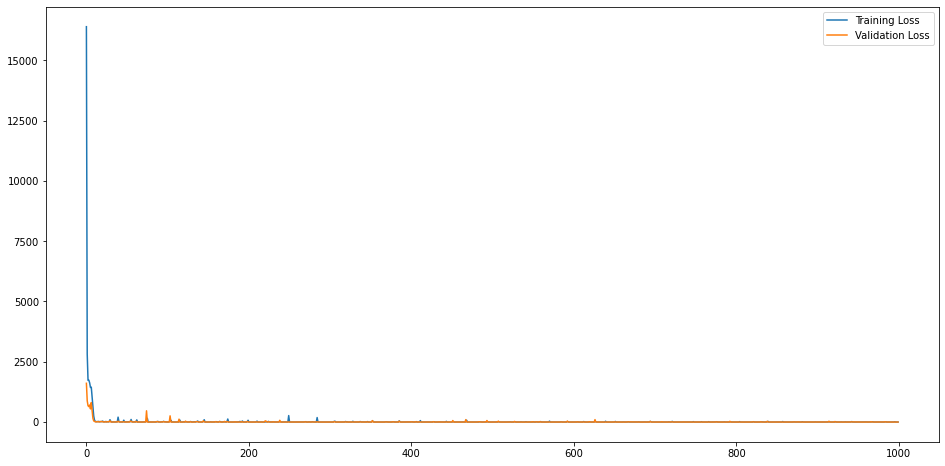

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
x = range(0, len(loss_list))
ax.plot(x, loss_list, label="Training Loss")
ax.plot(x, valid_loss_list, label="Validation Loss")
plt.legend()
plt.show()

## Testing

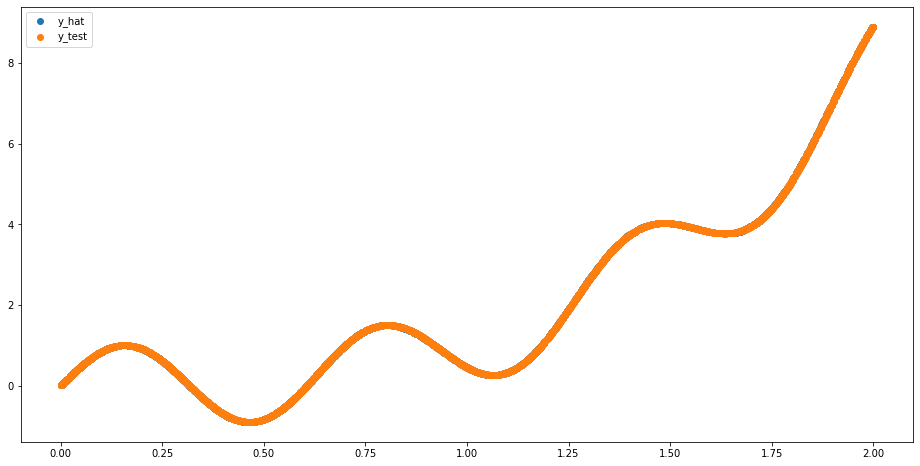

In [ ]:
t = torch.from_numpy(X_test)
with torch.no_grad():
    # forward
    y_hat_ej2 = nnet(t.to(device).float())

plt.figure(figsize=(16,8))
y_hat_ej2 = y_hat_ej2.cpu()
plt.scatter(X_test, y_hat_ej2, label='y_hat')
plt.scatter(X_test, y_test, label='y_test')
plt.legend()
plt.show()

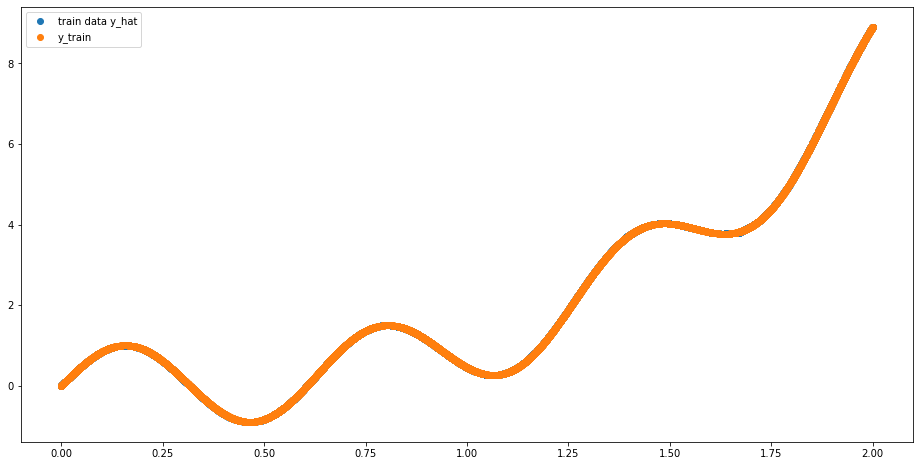

In [ ]:
t = torch.from_numpy(X_train)
with torch.no_grad():
    # forward
    y_train_hat = nnet(t.to(device).float())
    
plt.figure(figsize=(16,8))
y_train_hat = y_train_hat.cpu()
plt.scatter(X_train, y_train_hat, label='train data y_hat')
plt.scatter(X_train, y_train, label='y_train')
plt.legend()
plt.show()

In [ ]:
r2_score(y_test, y_hat_ej2)

0.9999974349837631

In [ ]:
r2_score(y_train, y_train_hat)

0.9999974999262653

## ¿Cómo saben que la red neuronal está haciendo overfitting?

Al graficar las predicciones vs el set de test, se puede observar que el modelo grafica la misma funcion que tienen los datos en ambooos sets, casi sin margen de error. 

Se que tiene bias bajo, porque agregué muchas capas con muchas neuronas (el size de las layers).

Luego compruebo con la metrica R2, que representa la proporcion de varianza que el modelo logra explicar. Tanto con los datos de train como los de test, R2 da un valor muy alto, 0.9999 (el valor máximo es 1).


## Agregar regularización y encontrar los parámetros correctos para lograr un buen fit. 

Agrego regularización, con una capa de dropout antes de cada funcion de activación.

REFERENCIAS:
1. [Is dropout applied before or after the non-linear activation function?](https://sebastianraschka.com/faq/docs/dropout-activation.html)
2. [Where should I place dropout layers in a Neural Network](https://stats.stackexchange.com/questions/240305/where-should-i-place-dropout-layers-in-a-neural-network)


In [ ]:
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=64, shuffle=True)

In [ ]:
class NNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=50, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(in_features=50, out_features=100, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.linear_3 = torch.nn.Linear(in_features=100, out_features=200, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.linear_4 = torch.nn.Linear(in_features=200, out_features=100, bias=True)
        self.relu_4 = torch.nn.ReLU()
        self.linear_5 = torch.nn.Linear(in_features=100, out_features=75, bias=True)
        self.relu_5 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=75, out_features=1, bias=True)
        self.dropout = torch.nn.Dropout(0.25)

    def forward(self, x): 
        # agrego regularizacion con dropout antes de las capas de ReLU
        x = self.linear_1(x)
        x = self.dropout(x)
        x = self.relu_1(x) 

        x = self.linear_2(x) 
        x = self.dropout(x)
        x = self.relu_2(x) 

        x = self.linear_3(x)
        x = self.dropout(x)
        x = self.relu_3(x)

        x = self.linear_4(x)
        x = self.dropout(x)
        x = self.relu_4(x)

        x = self.linear_5(x)
        x = self.dropout(x)
        x = self.relu_5(x)

        x = self.output(x) 
        return x

In [ ]:
nnet_with_dropout = NNet_with_dropout()
optimizer = torch.optim.Adam(nnet_with_dropout.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss(reduction="sum")

In [ ]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cpu


In [ ]:
nnet_with_dropout.to(device)

loss_list_with_dropout = list()
valid_loss_list_with_dropout = list()

for epoch in range(100): 
    
    running_loss = 0
    running_valid_loss = 0
    running_y_score = list()
    running_y_label = list()

    nnet_with_dropout.train()

    for i, data in enumerate(train_dataloader): #batches
        # Datos del batch
        X_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad() # que el optim ponga los gradientes en 0 
        y_batch_score = nnet_with_dropout(X_batch).reshape(-1)
        # y_batch_hat = torch.sigmoid(y_batch_score).reshape(-1)

        # backpropagation
        loss = loss_function(y_batch_score, y_batch)
        loss.backward() # hacer gradientes de score

        # actualizar parametros
        optimizer.step()

        running_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())
        running_y_label += list(y_batch.detach().cpu().numpy())
    
    loss_list_with_dropout.append(running_loss)
    
    nnet_with_dropout.eval()
    with torch.no_grad():
        for i, data in enumerate(valid_dataloader): 
            X_valid_batch, y_valid_batch = data
            X_valid_batch = X_valid_batch.to(device).float()
            y_valid_batch = y_valid_batch.to(device).float()

            # forward
            y_valid_batch_score = nnet_with_dropout(X_valid_batch).reshape(-1)
            valid_loss = loss_function(y_valid_batch_score, y_valid_batch) 

            running_valid_loss += valid_loss.item()
    
    # Calcular las metricas
    valid_loss_list_with_dropout.append(running_valid_loss)
    print("Epoch:", epoch, "\tTraining Loss:", running_loss, "\tValidation Loss:", running_valid_loss)

Epoch: 0 	Training Loss: 23342.50452709198 	Validation Loss: 1857.6034202575684
Epoch: 1 	Training Loss: 8417.846897125244 	Validation Loss: 2390.5537071228027
Epoch: 2 	Training Loss: 7681.314945220947 	Validation Loss: 3747.8564796447754
Epoch: 3 	Training Loss: 7246.52414894104 	Validation Loss: 2313.5158081054688
Epoch: 4 	Training Loss: 6504.895616531372 	Validation Loss: 3719.4900550842285
Epoch: 5 	Training Loss: 6273.3158531188965 	Validation Loss: 2393.160448074341
Epoch: 6 	Training Loss: 6132.914518356323 	Validation Loss: 2458.472848892212
Epoch: 7 	Training Loss: 5694.623252868652 	Validation Loss: 2986.1950454711914
Epoch: 8 	Training Loss: 5267.271985054016 	Validation Loss: 2363.4381065368652
Epoch: 9 	Training Loss: 5072.823998451233 	Validation Loss: 3130.3523712158203
Epoch: 10 	Training Loss: 5011.797845840454 	Validation Loss: 1743.2937755584717
Epoch: 11 	Training Loss: 4619.395458221436 	Validation Loss: 2663.9868755340576
Epoch: 12 	Training Loss: 4261.678664207

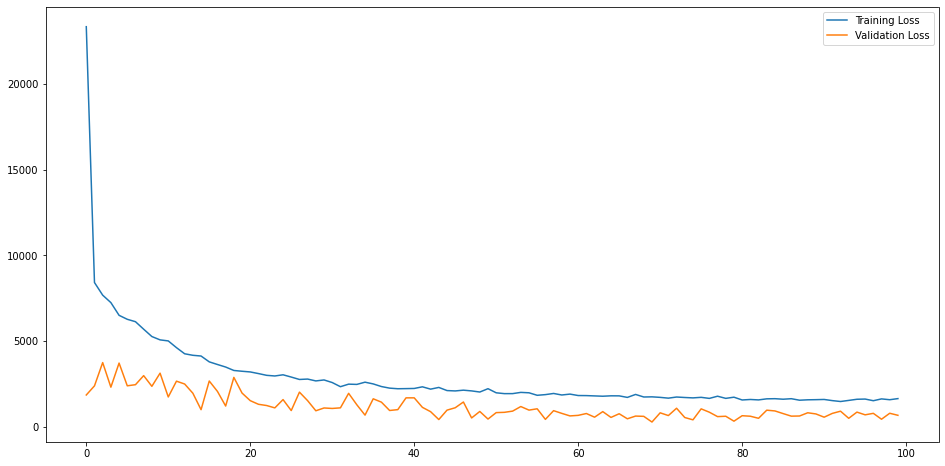

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
x = range(0, len(loss_list_with_dropout))
ax.plot(x, loss_list_with_dropout, label="Training Loss")
ax.plot(x, valid_loss_list_with_dropout, label="Validation Loss")
plt.legend()
plt.show()

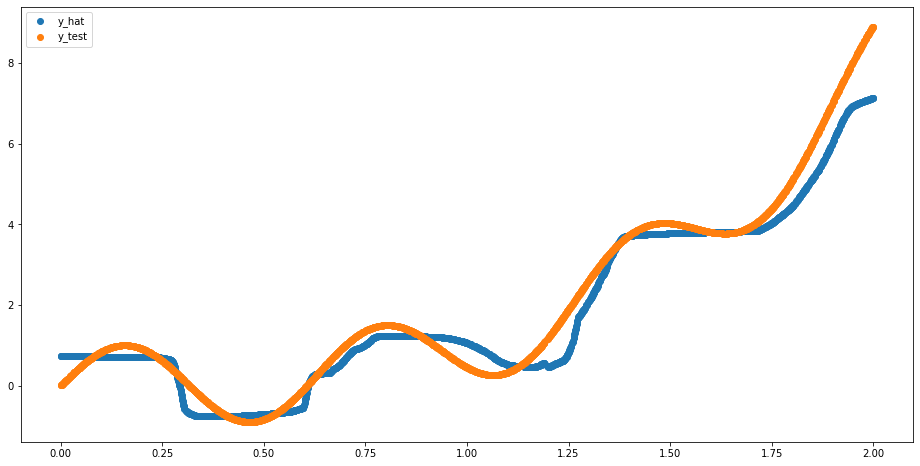

In [ ]:
t = torch.from_numpy(X_test)
with torch.no_grad():
    # forward
    y_hat_ej2_emb = nnet_with_dropout(t.to(device).float())

plt.figure(figsize=(16,8))
y_hat_ej2_emb = y_hat_ej2_emb.cpu()
plt.scatter(X_test, y_hat_ej2_emb, label='y_hat')
plt.scatter(X_test, y_test, label='y_test')
plt.legend()
plt.show()

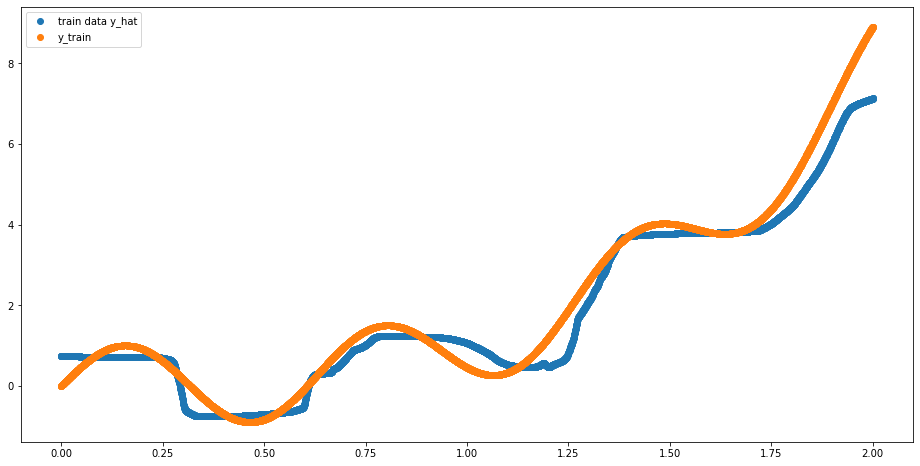

In [ ]:
t = torch.from_numpy(X_train)
with torch.no_grad():
    # forward
    y_train_hat_emb = nnet_with_dropout(t.to(device).float())
    
plt.figure(figsize=(16,8))
y_train_hat_emb = y_train_hat_emb.cpu()
plt.scatter(X_train, y_train_hat_emb, label='train data y_hat')
plt.scatter(X_train, y_train, label='y_train')
plt.legend()
plt.show()

In [ ]:
r2_score(y_test, y_hat_ej2_emb)

0.9574808957951196

In [ ]:
r2_score(y_train, y_train_hat_emb)

0.9574641099076593

# Ejercicio 3

3) Descargar el dataset desde el [siguiente link](https://drive.google.com/file/d/1r1vnIW0jL1LJBrT_QVcQz_Sjizwa0adR/view?usp=sharing). El dataset son compras de productos que diferentes clientes realizaron durante un black sales. El dataset contiene información sobre las transacciones y el objetivo es poder utilizar el dataset para crear diferentes modelos que puedan predecir cuánto un cliente está dispuesto a gastar en un producto en el futuro. Particularmente, vamos a tratar este problema como una clasificación binaria donde queremos averiguar si el cliente va a gastar mucha plata (más de 9000) o poca plata (menos de 9000).

1) Entrenar un modelo de deep learning que no utilice embeddings.

2) Entrenar un modelo de deep learning que utilice embeddings tanto para los productos como los usuarios. Realizar el mapeo de identificador de producto y usuarios a indices antes de separar el dataset en training, validation y testing.

3) Compare el score de cada modelo y comente lo necesario.


In [ ]:
dataset_path = "drive/MyDrive/CEIA/TPS/Deep Learning I/Examen/dataset_2.csv"
# dataset_path = "./dataset_2.csv"
dataset = pd.read_csv(dataset_path)
dataset.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 12 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   User_ID                     550068 non-null  int64  
 1   Product_ID                  550068 non-null  object 
 2   Gender                      550068 non-null  object 
 3   Age                         550068 non-null  object 
 4   Occupation                  550068 non-null  int64  
 5   City_Category               550068 non-null  object 
 6   Stay_In_Current_City_Years  550068 non-null  object 
 7   Marital_Status              550068 non-null  int64  
 8   Product_Category_1          550068 non-null  int64  
 9   Product_Category_2          376430 non-null  float64
 10  Product_Category_3          166821 non-null  float64
 11  Purchase                    550068 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 50.4+ MB


In [ ]:
dataset["purchase_label"] = dataset.Purchase.apply(lambda label: 0 if label < 9000 else 1)
dataset = dataset.drop('Purchase', axis=1)

In [ ]:
dataset.isna().sum()

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            173638
Product_Category_3            383247
purchase_label                     0
dtype: int64

In [ ]:
dataset.Gender.value_counts()

M    414259
F    135809
Name: Gender, dtype: int64

In [ ]:
dataset.Age.value_counts()

26-35    219587
36-45    110013
18-25     99660
46-50     45701
51-55     38501
55+       21504
0-17      15102
Name: Age, dtype: int64

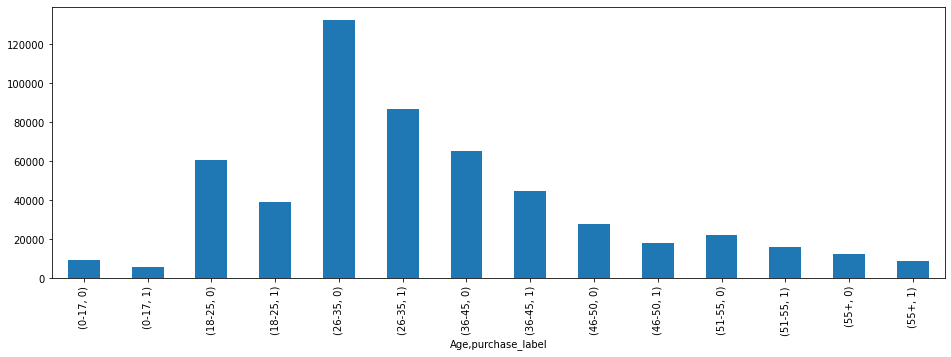

In [ ]:
plt.figure(figsize=(16,5))
dataset.groupby("Age").purchase_label.value_counts().plot(kind='bar')

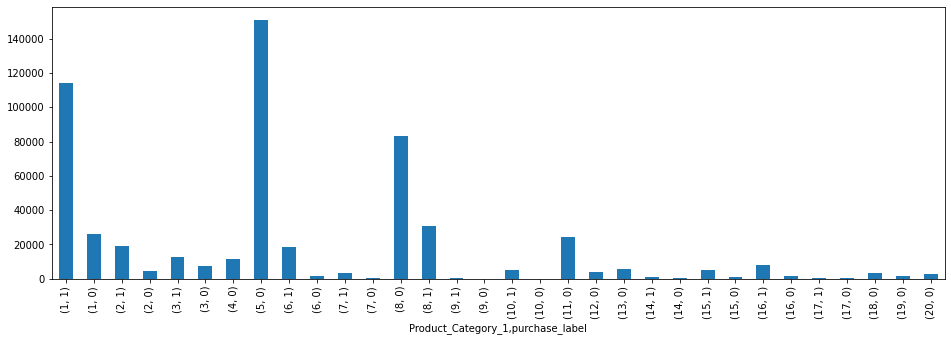

In [ ]:
plt.figure(figsize=(16,5))
dataset.groupby("Product_Category_1").purchase_label.value_counts().plot(kind='bar')

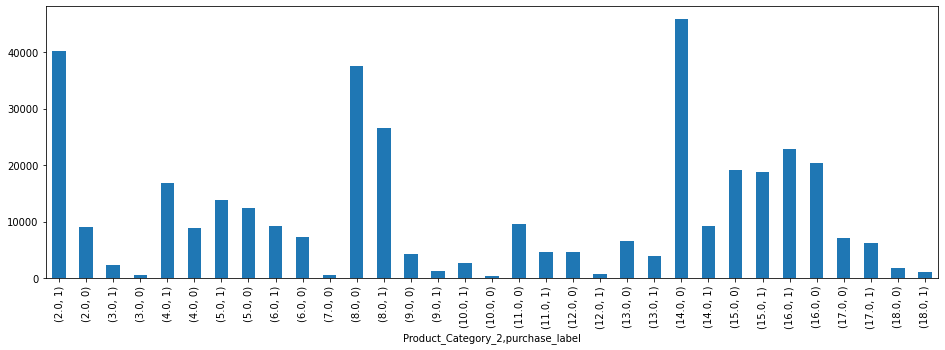

In [ ]:
plt.figure(figsize=(16,5))
dataset.groupby("Product_Category_2").purchase_label.value_counts().plot(kind='bar')

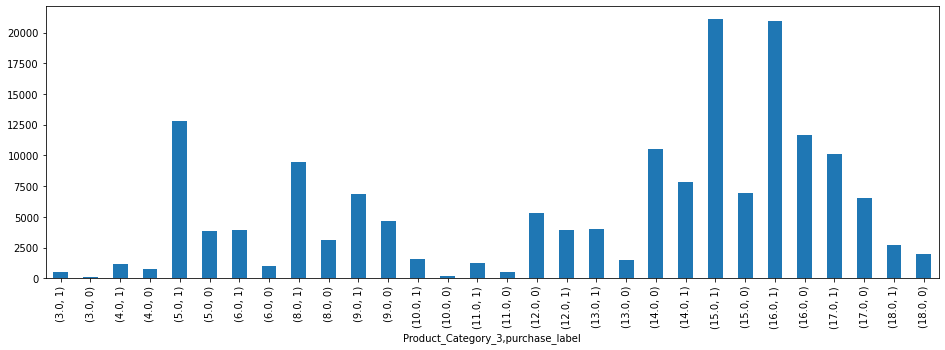

In [ ]:
plt.figure(figsize=(16,5))
dataset.groupby("Product_Category_3").purchase_label.value_counts().plot(kind='bar')

In [ ]:
dataset.Occupation.value_counts()

4     72308
0     69638
7     59133
1     47426
17    40043
20    33562
12    31179
14    27309
2     26588
16    25371
6     20355
3     17650
10    12930
5     12177
15    12165
11    11586
19     8461
13     7728
18     6622
9      6291
8      1546
Name: Occupation, dtype: int64

In [ ]:
dataset.City_Category.value_counts()

B    231173
C    171175
A    147720
Name: City_Category, dtype: int64

In [ ]:
dataset.Stay_In_Current_City_Years.value_counts()

1     193821
2     101838
3      95285
4+     84726
0      74398
Name: Stay_In_Current_City_Years, dtype: int64

In [ ]:
dataset.Product_Category_1.value_counts()

5     150933
1     140378
8     113925
11     24287
2      23864
6      20466
3      20213
4      11753
16      9828
15      6290
13      5549
10      5125
12      3947
7       3721
18      3125
20      2550
19      1603
14      1523
17       578
9        410
Name: Product_Category_1, dtype: int64

### Helper functions para el ejercicio 3

In [ ]:
class NNet(torch.nn.Module):
    def __init__(self, n_features, n_extra_layers, layer_neurons=100, device=""):
        super().__init__()
        self.layers = list()
        linear = torch.nn.Linear(in_features=n_features, out_features=layer_neurons, bias=True)
        self.layers.append(linear)
        relu = torch.nn.ReLU()
        self.layers.append(relu)
        for _ in range(n_extra_layers):
            linear = torch.nn.Linear(in_features=layer_neurons, out_features=layer_neurons, bias=True)
            self.layers.append(linear)
            relu = torch.nn.ReLU()
            self.layers.append(relu)
        for layer in self.layers:
            layer.to(device)
        self.output = torch.nn.Linear(in_features=layer_neurons, out_features=1, bias=True)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output(x)
        return x

### Armando los datasets para las pruebas

El primer approach que hice fue correr el modelo sin embeddings sobre el dataset con todas las columnas one-hot-encodeadas... pero el MSE era MUY grande aunque el tamaño del batch no.

Pensé que esto se debía a:
1. un error de mi EDA y que quizás alguna columna la podía dejar sin hacer one hot encoding o droppearla o
2. que quizás mi modelo necesitaba más capacidad.

Entonces decidí automatizar la creación de datasets y modelos para hacer distintos experimentos.

In [ ]:
################## CREATING DIFFERENT DATASETS FOR TESTING ##################

datasets = list()
################## OHE sobre todas las cols ##################
dataset['Product_Category_2'].fillna(0, inplace=True)
dataset['Product_Category_3'].fillna(0, inplace=True)

# ONE HOT ENCODING
one_hot_columns_dict = {
    "Age": "age",
    "Gender": "gender",
    "Occupation": "occ",
    "City_Category": "city",
    "Stay_In_Current_City_Years": "stay",
    "Product_Category_1": "prod_cat_1",
    "Product_Category_2": "prod_cat_2",
    "Product_Category_3": "prod_cat_3"
}

dataset_1 = one_hot(dataset, one_hot_columns_dict)
datasets.append(("dataset_1", dataset_1))

################## OHE sobre algunas cols ##################
# ONE HOT ENCODING
one_hot_columns_dict = {
    "Age": "age",
    "Gender": "gender",
    "City_Category": "city",
    "Stay_In_Current_City_Years": "stay",
}

dataset_2 = one_hot(dataset, one_hot_columns_dict)
datasets.append(("dataset_2", dataset_2))

################## SIN Product_Category_* y OHE sobre algunas cols ##################
# ONE HOT ENCODING
one_hot_columns_dict = {
    "Age": "age",
    "Gender": "gender",
    "City_Category": "city",
    "Stay_In_Current_City_Years": "stay",
}

dataset_3 = one_hot(dataset, one_hot_columns_dict)
dataset_3 = dataset_3.drop(columns=["Product_Category_1", "Product_Category_2", "Product_Category_3"])
datasets.append(("dataset_3", dataset_3))

################## SIN Product_Category 2 y 3 y OHE sobre algunas cols ##################
# ONE HOT ENCODING
one_hot_columns_dict = {
    "Age": "age",
    "Gender": "gender",
    "City_Category": "city",
    "Stay_In_Current_City_Years": "stay",
}

dataset_4 = one_hot(dataset, one_hot_columns_dict)
dataset_4 = dataset_4.drop(columns=["Product_Category_2", "Product_Category_3"])
datasets.append(("dataset_4", dataset_4))

################## SIN Occupation y OHE sobre algunas cols ##################
# ONE HOT ENCODING
one_hot_columns_dict = {
    "Age": "age",
    "Gender": "gender",
    "City_Category": "city",
    "Stay_In_Current_City_Years": "stay",
}

dataset_5 = one_hot(dataset, one_hot_columns_dict)
dataset_5 = dataset_5.drop(columns=["Occupation"])
datasets.append(("dataset_5", dataset_5))

for ds_name, ds in datasets:
    print(ds.shape)

(550068, 88)
(550068, 21)
(550068, 18)
(550068, 19)
(550068, 20)


In [ ]:
import pickle
n_epochs = 1000
path = "drive/MyDrive/CEIA/TPS/Deep Learning I/Examen/output/"
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"
print(device)

cuda:0


In [ ]:
################## TRAINING ##################
for ds_name, ds in datasets:
    X = ds.drop(columns=["purchase_label", 'Product_ID', 'User_ID'])
    y = ds["purchase_label"]

    ################## NORMALIZE ##################
    X_norm = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

    ################## DATALOADERS ##################
    X_train, X_valid, y_train, y_valid = train_test_split(X_norm, y, test_size=0.25, random_state=12)

    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()
    X_valid = X_valid.to_numpy()
    y_valid = y_valid.to_numpy()

    y_train = y_train.reshape(-1)
    y_valid = y_valid.reshape(-1)

    train = MyDataset(X_train, y_train)
    valid = MyDataset(X_valid, y_valid)
    train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
    valid_dataloader = DataLoader(valid, batch_size=64, shuffle=True)
    ################## TRAINING ##################
    n_features = X_norm.shape[1]

    nnets = [("0_extra_100_neurons", NNet(n_features, n_extra_layers=0, layer_neurons=100, device=device)),
             ("1_extra_100_neurons", NNet(n_features, n_extra_layers=1, layer_neurons=100, device=device)),
             ("2_extra_100_neurons", NNet(n_features, n_extra_layers=2, layer_neurons=100, device=device)),
             ("3_extra_100_neurons", NNet(n_features, n_extra_layers=3, layer_neurons=100, device=device))]

    for nnet_name, nnet in nnets:
        optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
        loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")

        print("*************** {} {} ***************".format(ds_name, nnet_name))

        nnet.to(device)
        loss_list = list()
        valid_loss_list = list()
        train_auc = list()
        valid_auc = list()

        for epoch in range(n_epochs):  # epochs
            epoch_loss = 0
            epoch_valid_loss = 0
            epoch_acc = 0
            running_y_score = list()
            running_y_label = list()
            valid_y_score = list()
            valid_y_label = list()

            nnet.train()
            for i, data in enumerate(train_dataloader):  # batches
                # Datos del batch
                X_batch, y_batch = data
                X_batch = X_batch.to(device).float()
                y_batch = y_batch.to(device).float()

                # forward
                optimizer.zero_grad()  # que el optim ponga los gradientes en 0
                y_batch_score = nnet(X_batch).reshape(-1)
                y_batch_hat = torch.sigmoid(y_batch_score).reshape(-1)

                # backpropagation
                loss = loss_function(y_batch_score, y_batch)
                loss.backward()  # hacer gradientes de score

                # actualizar parametros
                optimizer.step()

                epoch_loss += loss.item()
                running_y_score += list(y_batch_score.detach().cpu().numpy())
                running_y_label += list(y_batch.detach().cpu().numpy())

            nnet.eval()

            with torch.no_grad():
                for i, data in enumerate(valid_dataloader):
                    X_valid_batch, y_valid_batch = data
                    X_valid_batch = X_valid_batch.to(device).float()
                    y_valid_batch = y_valid_batch.to(device).float()

                    # forward
                    y_valid_batch_score = nnet(X_valid_batch).reshape(-1)
                    y_valid_batch_hat = torch.sigmoid(y_valid_batch_score).reshape(-1)

                    valid_loss = loss_function(y_valid_batch_score, y_valid_batch)

                    epoch_valid_loss += valid_loss.item()

                    valid_y_score += list(y_valid_batch_score.detach().cpu().numpy())
                    valid_y_label += list(y_valid_batch.detach().cpu().numpy())

            fpr, tpr, _ = metrics.roc_curve(running_y_label, running_y_score)
            epoch_auc = metrics.auc(fpr, tpr)

            val_fpr, val_tpr, _ = metrics.roc_curve(valid_y_label, valid_y_score)
            epoch_valid_auc = metrics.auc(val_fpr, val_tpr)

            train_auc.append(epoch_auc)
            valid_auc.append(epoch_valid_auc)
            loss_list.append(epoch_loss)
            valid_loss_list.append(epoch_valid_loss)

            print("Epoch:", epoch,
                  "\tTraining Loss:", epoch_loss,
                  "\tValidation Loss:", epoch_valid_loss,
                  "\tAUC:", epoch_auc)
            
            # guardando las métricas de los experimentos en .pickle para poder accederlas después
            if epoch % 100 == 0:
                with open(path + 'loss_list_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
                    pickle.dump(loss_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

                with open(path + 'valid_loss_list_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
                    pickle.dump(valid_loss_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

                with open(path + 'train_auc_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
                    pickle.dump(train_auc, handle, protocol=pickle.HIGHEST_PROTOCOL)

                with open(path + 'valid_auc_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
                    pickle.dump(valid_auc, handle, protocol=pickle.HIGHEST_PROTOCOL)

                with open(path + 'nnet_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
                    pickle.dump(nnet, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(path + 'loss_list_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
            pickle.dump(loss_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(path + 'valid_loss_list_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
            pickle.dump(valid_loss_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(path + 'train_auc_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
            pickle.dump(train_auc, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(path + 'valid_auc_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
            pickle.dump(valid_auc, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(path + 'nnet_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
            pickle.dump(nnet, handle, protocol=pickle.HIGHEST_PROTOCOL)


### Eligiendo el mejor experimento, para usar ese dataset en el modelo que tiene embeddings

In [ ]:
path = "./ejercicio 3/output/"
nnets = [("0_extra_100_neurons", 0),
             ("1_extra_100_neurons", 0),
             ("2_extra_100_neurons", 0),
             ("3_extra_100_neurons", 0)]

In [ ]:
experiment_results = dict()

In [ ]:
import pickle
for ds_name, ds in datasets[:-1]:
    for nnet_name, nnet in nnets:
        experiment = dict()
        with open(path + 'loss_list_{}_{}.pickle'.format(ds_name, nnet_name), 'rb') as handle:
            experiment["loss_list"] = pickle.load(handle)

        with open(path + 'valid_loss_list_{}_{}.pickle'.format(ds_name, nnet_name), 'rb') as handle:
            experiment["valid_loss"] = pickle.load(handle)

        with open(path + 'train_auc_{}_{}.pickle'.format(ds_name, nnet_name), 'rb') as handle:
            experiment["train_auc"] = pickle.load(handle)

        with open(path + 'valid_auc_{}_{}.pickle'.format(ds_name, nnet_name), 'rb') as handle:
            experiment["valid_auc"] = pickle.load(handle)

        with open(path + 'nnet_{}_{}.pickle'.format(ds_name, nnet_name), 'rb') as handle:
            experiment["nnet"] = pickle.load(handle)
        
        experiment_results["{}_{}".format(ds_name, nnet_name)] = experiment

[]

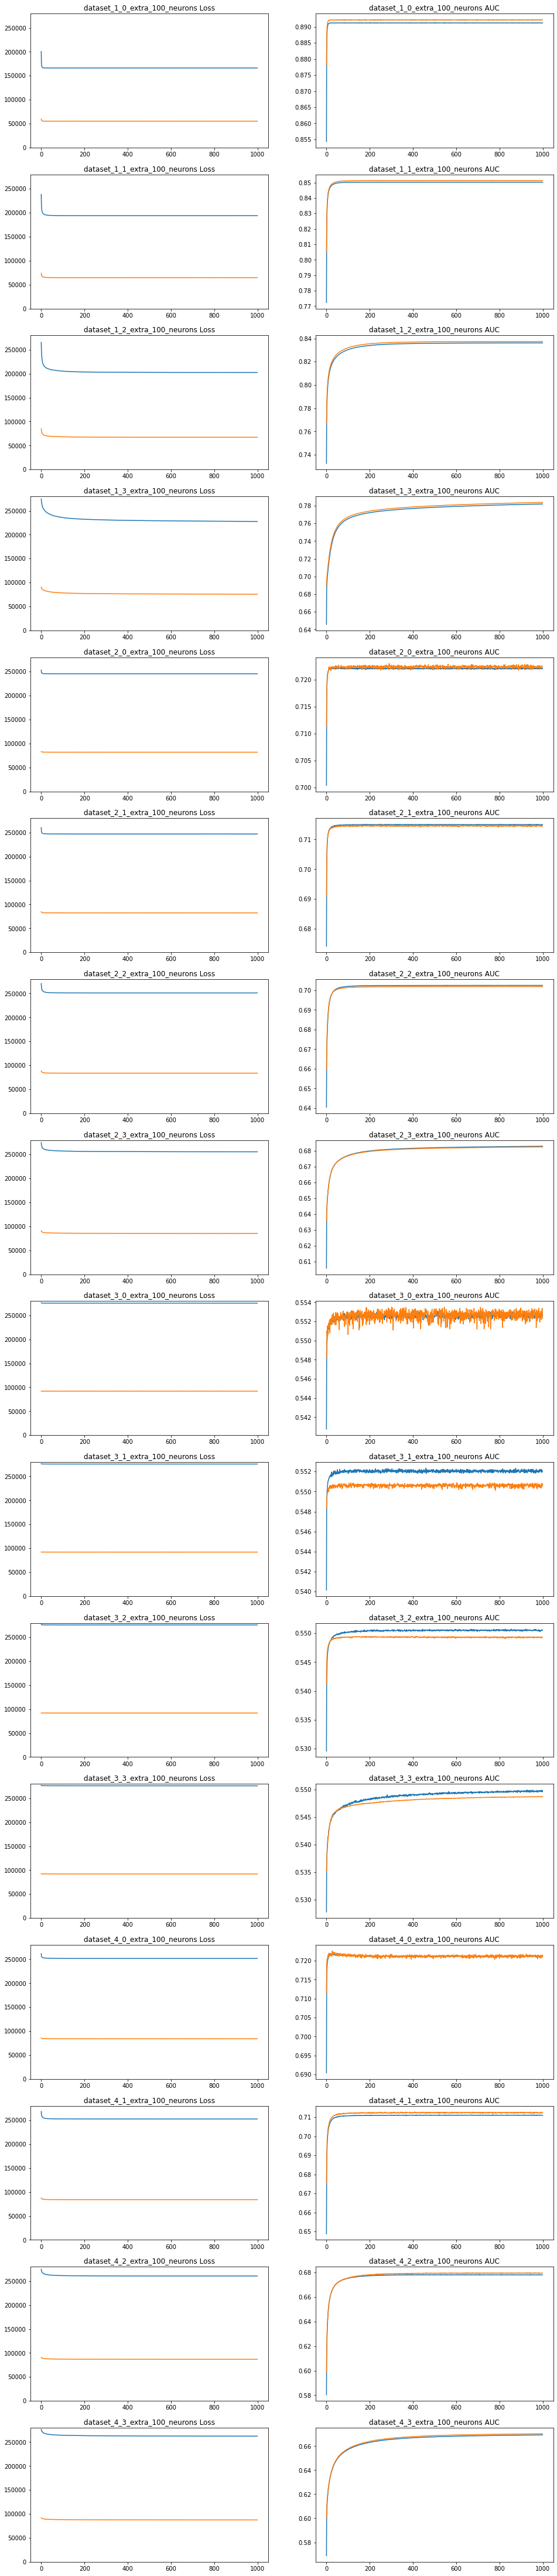

In [ ]:
fig, ax = plt.subplots(len(experiment_results),2, figsize=(16, 5*16))
i = 0
for exp in experiment_results:
    x = range(0, len(experiment_results[exp]["loss_list"]))
    ax[i][0].plot(x, experiment_results[exp]["loss_list"], label="Training Loss")
    ax[i][0].plot(x, experiment_results[exp]["valid_loss"], label="Validation Loss")
    ax[i][0].set_ylim([0, 280000])
    ax[i][0].set_title(exp + " Loss")
    x = range(0, len(experiment_results[exp]["train_auc"]))
    ax[i][1].plot(x, experiment_results[exp]["train_auc"], label="Training AUC")
    ax[i][1].plot(x, experiment_results[exp]["valid_auc"], label="Validation AUC")
    ax[i][1].set_title(exp + " AUC")
    i += 1
plt.plot()

Elijo quedarme con el primer dataset con una capa de 100 neuronas, ya que es el que tiene mejor AUC. Este es el dataset que tiene todas las columnas con one hot encoding. 

(Si, hice todos estos experimentos sin necesidad, porque como decía al comienzo... este era mi primer approach)

### Testing 
Ahora procedo a hacer un pequeño testing para validar:

In [ ]:
ds = dataset_1

X = ds.drop(columns=["purchase_label", 'Product_ID', 'User_ID'])
y = ds["purchase_label"]

################## NORMALIZE ##################
X_norm = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

################## DATALOADERS ##################
X_train, X_valid, y_train, y_valid = train_test_split(X_norm, y, test_size=0.25, random_state=12)

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_valid = X_valid.to_numpy()
y_valid = y_valid.to_numpy()

y_train = y_train.reshape(-1)
y_valid = y_valid.reshape(-1)

train = MyDataset(X_train, y_train)
valid = MyDataset(X_valid, y_valid)
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=64, shuffle=True)

In [ ]:
nnet = experiment_results["dataset_1_0_extra_100_neurons"]["nnet"]

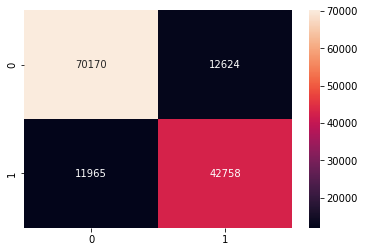

In [ ]:
t = torch.from_numpy(X_valid)
with torch.no_grad():
    # forward
    y_score = nnet(t.to(device).float()).reshape(-1)
    y_hat = torch.sigmoid(y_score).reshape(-1).cpu().numpy()
    y_hat = (y_hat > 0.5) * 1

import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, y_hat)
f = sns.heatmap(cm, annot=True, fmt='d')


## NNet con embeddings!!!! 
Mantengo el mismo dataset elegido y la misma red (pero ahora con embeddings) para poder comparar y llegar a conclusiones

### Convierto los user IDs en un índice

In [ ]:
len(np.unique(dataset_1.User_ID))

5891

In [ ]:
user_id = dataset_1.User_ID
user_id

0         1000001
1         1000001
2         1000001
3         1000001
4         1000002
           ...   
550063    1006033
550064    1006035
550065    1006036
550066    1006038
550067    1006039
Name: User_ID, Length: 550068, dtype: int64

In [ ]:
unique = np.unique(user_id)
index = np.arange(0, len(unique))
user_id_to_index = {key: value for key, value in zip(unique, index)}

In [ ]:
user_idx = np.array([user_id_to_index[user] for user in user_id])

In [ ]:
print(min(user_idx))
print(max(user_idx))

0
5890


In [ ]:
print(max(unique)) # el valor maximo es 1006040
print(user_id_to_index[1006040]) # deberia tener el indice en 5890 (maximo indice)

1006040
5890


### Convierto los product IDs en un índice

In [ ]:
product_id = dataset_1.Product_ID
product_id

0         P00069042
1         P00248942
2         P00087842
3         P00085442
4         P00285442
            ...    
550063    P00372445
550064    P00375436
550065    P00375436
550066    P00375436
550067    P00371644
Name: Product_ID, Length: 550068, dtype: object

In [ ]:
unique = np.unique(product_id)
index = np.arange(0, len(unique))
product_id_to_index = {key: value for key, value in zip(unique, index)}

In [ ]:
product_idx = np.array([product_id_to_index[product] for product in product_id])

In [ ]:
print(min(product_idx))
print(max(product_idx))

0
3630


In [ ]:
print(max(unique)) # el valor maximo es P0099942
print(product_id_to_index["P0099942"]) # deberia tener el indice en 3630 (maximo indice)

P0099942
3630


### Dataset con embedding

In [ ]:
class CustomDatasetWithEmb(Dataset): #hereda de la clase dataset de pytorch

    def __init__(self, X, user_idx, product_idx, y):
        # ahora toma de input X, Y y los ids de usuarios y de productos
        super().__init__()
        self.X = X
        self.user_idx = user_idx
        self.product_idx = product_idx
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        # el __getitem__ es el iterador
        return self.X[idx], self.user_idx[idx], self.product_idx[idx], self.y[idx]

In [ ]:
# dataset_1.drop(columns=["user_idx", "product_idx"], inplace=True)

In [ ]:
ds = dataset_1

X = ds.drop(columns=["purchase_label", 'Product_ID', 'User_ID'])
y = ds["purchase_label"]

################## NORMALIZE ##################
X_norm = (X - np.min(X, axis=0)) / (np.max(X, axis=0) - np.min(X, axis=0))

In [ ]:
ds_indices = [user_id_to_index[u_id] for u_id in ds.User_ID]
ds["user_idx"] = ds_indices

In [ ]:
ds_indices = [product_id_to_index[p_id] for p_id in ds.Product_ID]
ds["product_idx"] = ds_indices

In [ ]:
ds[["user_idx", "product_idx"]].join(X_norm)

,user_idx,product_idx,Marital_Status,age_18-25,age_26-35,age_36-45,age_46-50,age_51-55,age_55+,gender_M,...,prod_cat_3_9.0,prod_cat_3_10.0,prod_cat_3_11.0,prod_cat_3_12.0,prod_cat_3_13.0,prod_cat_3_14.0,prod_cat_3_15.0,prod_cat_3_16.0,prod_cat_3_17.0,prod_cat_3_18.0
0,0,672,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2376,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0,852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,2734,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550063,5883,3567,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550064,5885,3568,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550065,5886,3568,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
550066,5888,3568,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
embeddings_ds = ds[["user_idx", "product_idx"]].join(X_norm)
X_train, X_valid, y_train, y_valid = train_test_split(embeddings_ds, y, test_size=0.25, random_state=12)

user_idx_train = X_train["user_idx"].to_numpy()
user_idx_valid = X_valid["user_idx"].to_numpy()

product_idx_train = X_train["product_idx"].to_numpy()
product_idx_valid = X_valid["product_idx"].to_numpy()

X_train = X_train.drop(columns=["product_idx", "user_idx"]).to_numpy()
y_train = y_train.to_numpy()

X_valid = X_valid.drop(columns=["product_idx", "user_idx"]).to_numpy()
y_valid = y_valid.to_numpy()

y_train = y_train.reshape(-1)
y_valid = y_valid.reshape(-1)

In [ ]:
train = CustomDatasetWithEmb(X_train, user_idx_train, product_idx_train, y_train)
valid = CustomDatasetWithEmb(X_valid, user_idx_valid, product_idx_valid, y_valid)
train_dataloader = DataLoader(train, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid, batch_size=64, shuffle=True)

### Creo el modelo

In [ ]:
class NNetWithEmbeddings(torch.nn.Module):

    def __init__(self, number_of_users, number_of_products, d_users, d_products):
        # recibe la cantidad de filas y de columnas d tanto para usuarios como para productos
        # d es la dimension del embedding, puede ser 8, 16, 32, etc

        super().__init__()
        
        # creo un modulo embedding de Torch
        self.users_embedding = torch.nn.Embedding(num_embeddings=number_of_users, embedding_dim=d_users)
        
        # creo un modulo embedding de Torch
        self.products_embedding = torch.nn.Embedding(num_embeddings=number_of_products, embedding_dim=d_products)

        # el resto de las capas son las mismas
        self.linear_1 = torch.nn.Linear(in_features=(85 + d_users + d_products), 
                                        out_features=100, bias=True) 
        self.relu_1 = torch.nn.ReLU()
#         self.linear_2 = torch.nn.Linear(in_features=150, out_features=100, bias=True) 
#         self.relu_2 = torch.nn.ReLU()
#         self.linear_3 = torch.nn.Linear(in_features=100, out_features=75, bias=True) 
#         self.relu_3 = torch.nn.ReLU()
#         self.linear_4 = torch.nn.Linear(in_features=75, out_features=50, bias=True) 
#         self.relu_4 = torch.nn.ReLU()
        self.output = torch.nn.Linear(in_features=100, out_features=1, bias=True)

    def forward(self, x, user_idx, product_idx):
        # inicializo los embedings de las filas que le pase
        user_emb = self.users_embedding(user_idx) 
        prod_emb = self.products_embedding(product_idx) 

        # quiero concatenar las features (x) con las nuevas columnas del embedding
        final_input = torch.cat([x, user_emb, prod_emb], dim=1) 

        x = self.linear_1(final_input) 
        x = self.relu_1(x)
#         x = self.linear_2(x) 
#         x = self.relu_2(x)
#         x = self.linear_3(x) 
#         x = self.relu_3(x)
#         x = self.linear_4(x) 
#         x = self.relu_4(x)     
        x = self.output(x) 
        return x

In [ ]:
nnet = NNetWithEmbeddings(number_of_users=len(user_idx), number_of_products=len(product_idx), d_users=8, d_products=8)

optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)

loss_function = torch.nn.BCEWithLogitsLoss(reduction="sum")

### Training modelo con embeddings

In [ ]:
################## TRAINING ##################
nnet.to(device)
loss_list = list()
valid_loss_list = list()
train_auc = list()
valid_auc = list()
ds_name = "dataset_1"
nnet_name = "embeddings"

for epoch in range(200):  # epochs
    epoch_loss = 0
    epoch_valid_loss = 0
    epoch_acc = 0
    running_y_score = list()
    running_y_label = list()
    valid_y_score = list()
    valid_y_label = list()

    nnet.train()
    for i, data in enumerate(train_dataloader):  # batches
        # Datos del batch
        X_batch, user_idx_batch, product_idx_batch, y_batch = data
        X_batch = X_batch.to(device).float()
        user_idx_batch = user_idx_batch.to(device)
        product_idx_batch = product_idx_batch.to(device)
        y_batch = y_batch.to(device).float()

        # forward
        optimizer.zero_grad()  # que el optim ponga los gradientes en 0
        y_batch_score = nnet(X_batch, user_idx_batch, product_idx_batch).reshape(-1)
        y_batch_hat = torch.sigmoid(y_batch_score).reshape(-1)

        # backpropagation
        loss = loss_function(y_batch_score, y_batch)
        loss.backward()  # hacer gradientes de score

        # actualizar parametros
        optimizer.step()

        epoch_loss += loss.item()
        running_y_score += list(y_batch_score.detach().cpu().numpy())
        running_y_label += list(y_batch.detach().cpu().numpy())

    nnet.eval()

    with torch.no_grad():
        for i, data in enumerate(valid_dataloader):
            X_valid_batch, user_idx_valid_batch, product_idx_valid_batch, y_valid_batch = data
            X_valid_batch = X_valid_batch.to(device).float()
            user_idx_valid_batch = user_idx_valid_batch.to(device)
            product_idx_valid_batch = product_idx_valid_batch.to(device)
            y_valid_batch = y_valid_batch.to(device).float()

            # forward
            y_valid_batch_score = nnet(X_valid_batch, user_idx_valid_batch, product_idx_valid_batch).reshape(-1)
            y_valid_batch_hat = torch.sigmoid(y_valid_batch_score).reshape(-1)

            valid_loss = loss_function(y_valid_batch_score, y_valid_batch)

            epoch_valid_loss += valid_loss.item()

            valid_y_score += list(y_valid_batch_score.detach().cpu().numpy())
            valid_y_label += list(y_valid_batch.detach().cpu().numpy())

    fpr, tpr, _ = metrics.roc_curve(running_y_label, running_y_score)
    epoch_auc = metrics.auc(fpr, tpr)

    val_fpr, val_tpr, _ = metrics.roc_curve(valid_y_label, valid_y_score)
    epoch_valid_auc = metrics.auc(val_fpr, val_tpr)

    train_auc.append(epoch_auc)
    valid_auc.append(epoch_valid_auc)
    loss_list.append(epoch_loss)
    valid_loss_list.append(epoch_valid_loss)

    print("Epoch:", epoch,
          "\tTraining Loss:", epoch_loss,
          "\tValidation Loss:", epoch_valid_loss,
          "\tAUC:", epoch_auc)
    if epoch % 100 == 0:
        with open(path + 'loss_list_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
            pickle.dump(loss_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(path + 'valid_loss_list_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
            pickle.dump(valid_loss_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(path + 'train_auc_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
            pickle.dump(train_auc, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(path + 'valid_auc_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
            pickle.dump(valid_auc, handle, protocol=pickle.HIGHEST_PROTOCOL)

        with open(path + 'nnet_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
            pickle.dump(nnet, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(path + 'loss_list_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
    pickle.dump(loss_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(path + 'valid_loss_list_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
    pickle.dump(valid_loss_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(path + 'train_auc_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
    pickle.dump(train_auc, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(path + 'valid_auc_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
    pickle.dump(valid_auc, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(path + 'nnet_{}_{}.pickle'.format(ds_name, nnet_name), 'wb') as handle:
    pickle.dump(nnet, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch: 0 	Training Loss: 127535.06064665318 	Validation Loss: 38960.78881692886 	AUC: 0.933686601311656
Epoch: 1 	Training Loss: 113488.57668066025 	Validation Loss: 37264.34581375122 	AUC: 0.9486792160028208
Epoch: 2 	Training Loss: 108023.40939557552 	Validation Loss: 36369.86219930649 	AUC: 0.9539406892125061
Epoch: 3 	Training Loss: 104740.62240958214 	Validation Loss: 36145.207914829254 	AUC: 0.9568985494676201
Epoch: 4 	Training Loss: 102711.83800268173 	Validation Loss: 36092.93926906586 	AUC: 0.9586829253361117
Epoch: 5 	Training Loss: 101253.30188298225 	Validation Loss: 35825.45152902603 	AUC: 0.9599106653659324
Epoch: 6 	Training Loss: 100044.35623884201 	Validation Loss: 35944.85079193115 	AUC: 0.9609283373348567
Epoch: 7 	Training Loss: 98944.91267609596 	Validation Loss: 35910.14305973053 	AUC: 0.96183662607946
Epoch: 8 	Training Loss: 97933.07601714134 	Validation Loss: 35904.40478658676 	AUC: 0.9626808863171774
Epoch: 9 	Training Loss: 96937.45952701569 	Validation Loss

Epoch: 79 	Training Loss: 62423.12369982898 	Validation Loss: 55355.578614234924 	AUC: 0.9852890859120502
Epoch: 80 	Training Loss: 62161.53248708695 	Validation Loss: 55658.77437257767 	AUC: 0.9854126748474762
Epoch: 81 	Training Loss: 61994.138040840626 	Validation Loss: 55673.215363025665 	AUC: 0.985480324726255
Epoch: 82 	Training Loss: 61839.42508506775 	Validation Loss: 55971.166399002075 	AUC: 0.9855658266008939
Epoch: 83 	Training Loss: 61583.82355611026 	Validation Loss: 56449.994094371796 	AUC: 0.9856852074806125
Epoch: 84 	Training Loss: 61482.68795788288 	Validation Loss: 56309.34412050247 	AUC: 0.9857321417078275
Epoch: 85 	Training Loss: 61234.63623958826 	Validation Loss: 56595.26164507866 	AUC: 0.9858538309180264
Epoch: 86 	Training Loss: 61135.673934578896 	Validation Loss: 57053.32615327835 	AUC: 0.9858884938388526
Epoch: 87 	Training Loss: 60932.9777623415 	Validation Loss: 56855.20000267029 	AUC: 0.9859834891070676
Epoch: 88 	Training Loss: 60757.81176555157 	Valida

Epoch: 157 	Training Loss: 53806.42127028108 	Validation Loss: 67066.70057582855 	AUC: 0.9890967380528994
Epoch: 158 	Training Loss: 53717.83088058233 	Validation Loss: 67205.12381362915 	AUC: 0.9891375524165036
Epoch: 159 	Training Loss: 53680.673178901896 	Validation Loss: 66961.78003454208 	AUC: 0.9891465105082782
Epoch: 160 	Training Loss: 53674.69046270847 	Validation Loss: 66990.8989701271 	AUC: 0.9891547742382649
Epoch: 161 	Training Loss: 53532.976874530315 	Validation Loss: 67526.02742862701 	AUC: 0.9892056288652458
Epoch: 162 	Training Loss: 53563.125661849976 	Validation Loss: 67214.26108169556 	AUC: 0.9892019533786456
Epoch: 163 	Training Loss: 53487.721484452486 	Validation Loss: 67543.8551030159 	AUC: 0.9892284367193253
Epoch: 164 	Training Loss: 53382.179452830926 	Validation Loss: 67720.07297253609 	AUC: 0.9892656213413928
Epoch: 165 	Training Loss: 53311.60471639782 	Validation Loss: 67386.54024124146 	AUC: 0.989299795783854
Epoch: 166 	Training Loss: 53216.00165892392

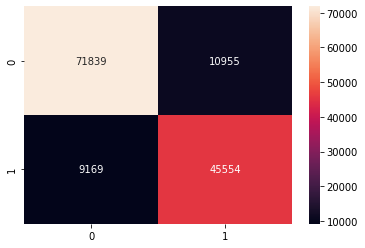

In [ ]:
t = torch.from_numpy(X_valid)
with torch.no_grad():
    # forward
    user_idx_valid_t = torch.from_numpy(user_idx_valid).to(device)
    product_idx_valid_t = torch.from_numpy(product_idx_valid).to(device)
    y_score = nnet(t.to(device).float(), user_idx_valid_t, product_idx_valid_t).reshape(-1)
    y_hat = torch.sigmoid(y_score).reshape(-1).cpu().numpy()
    y_hat = (y_hat > 0.5) * 1

import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_valid, y_hat)
f = sns.heatmap(cm, annot=True, fmt='d')

[]

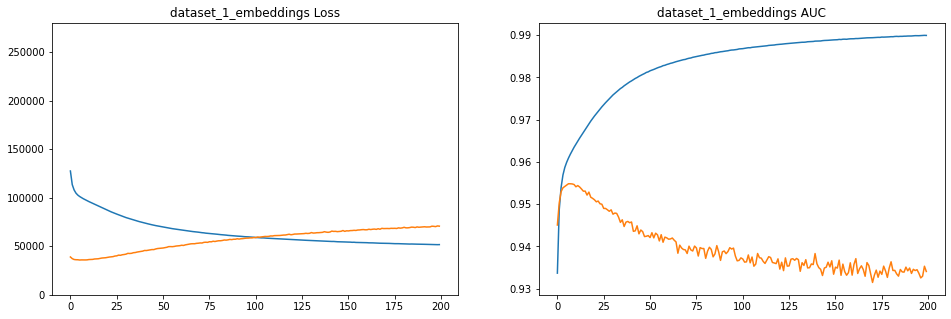

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(16, 5))
exp = "{}_{}".format(ds_name, nnet_name)
x = range(0, len(loss_list))
ax[0].plot(x, loss_list, label="Training Loss")
ax[0].plot(x, valid_loss_list, label="Validation Loss")
ax[0].set_ylim([0, 280000])
ax[0].set_title(exp + " Loss")
x = range(0, len(train_auc))
ax[1].plot(x, train_auc, label="Training AUC")
ax[1].plot(x, valid_auc, label="Validation AUC")
ax[1].set_title(exp + " AUC")
plt.plot()

## Compare el score de cada modelo y comente lo necesario

Para el modelo sin embeddings se hicieron muchas pruebas:

1. cambiando el dataset
2. modelos sin embeddings:
    * con una capa linear y una ReLU
    * con dos capas lineares y sus respectivas ReLU
    * con 3 capas lineares y sus respectivas ReLU
    * con 4 capas lineares y sus respectivas ReLU
    
Se eligió el modelo con mejor AUC para agregarle embeddings y hacer la siguiente prueba con el mismo dataset.

El modelo elegido es muy simple, con una capa linear de 100 neuronas y activación ReLU y otra capa linear para la salida.

En el modelo sin embeddings se puede ver que el training Loss baja muy poco y muy lento. Con 1000 epochs se logró un 0.86 de AUC.

En el modelo con embeddings el training loss disminuye muchísimo más con tan solo 200 epochs pero el validation loss aumenta. Y al ver el AUC de train veo que el modelo aprende de memoria el set de train, pero performa muy mal en validation. Puedo decir que tengo un caso de overfitting.

# Ejercicio 4
Se tiene la función $y = a * log(b) + b * c^2$. Calcular las derivadas de y respecto a los parámetros a, b, c, evaluando en los valores a=2, b=10, c=0.5. Se deben calcular las derivadas por los siguientes métodos:

1. Utilizando derivadas analíticas (symbolic differentiation).
2. Utilizando límite con un delta numérico pequeño (numerical differentiation).
3. Utilizando grafos y la regla de la cadena (chain rule differentiation)
4. Utilizando PyTorch (automatic differentiation).

## 1. Utilizando derivadas analíticas (symbolic differentiation).

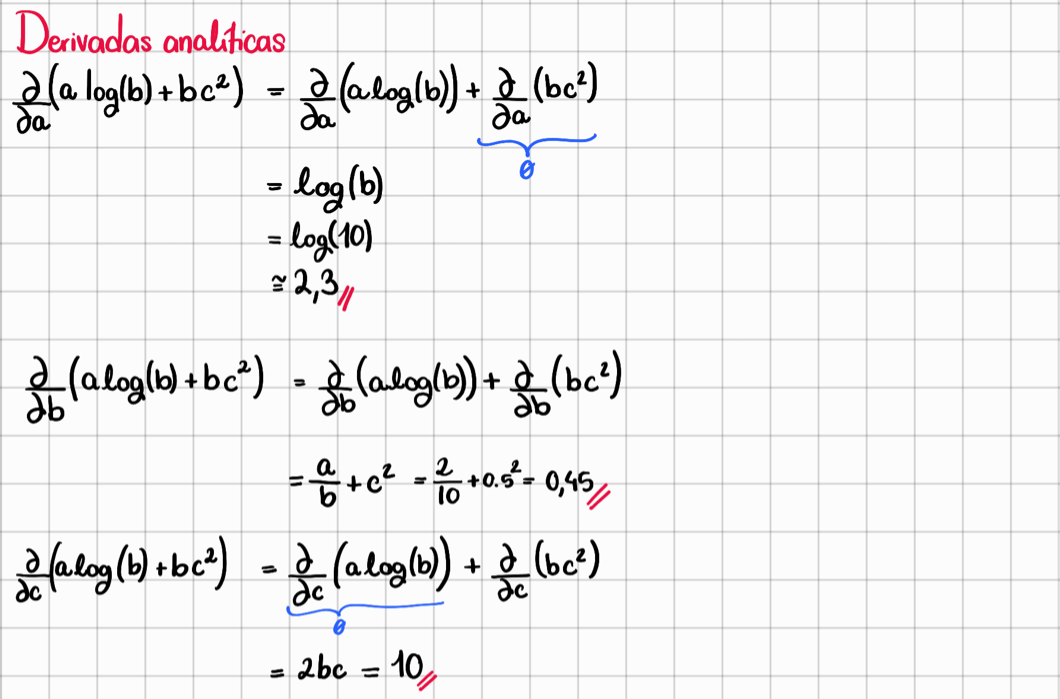

## 2. Utilizando límite con un delta numérico pequeño (numerical differentiation).

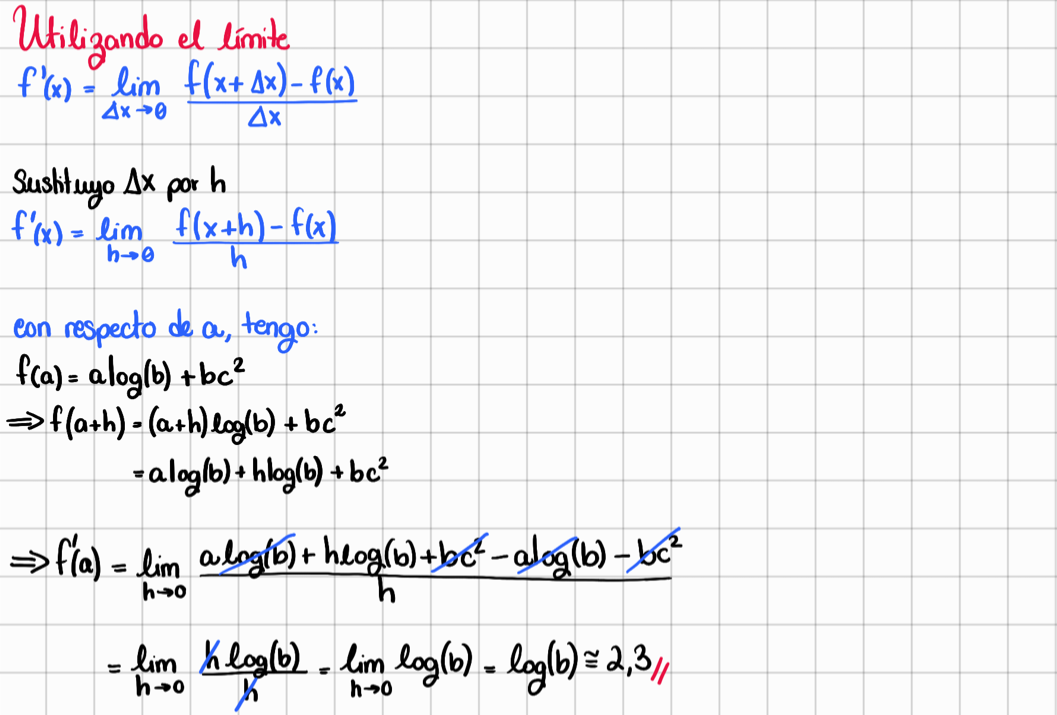

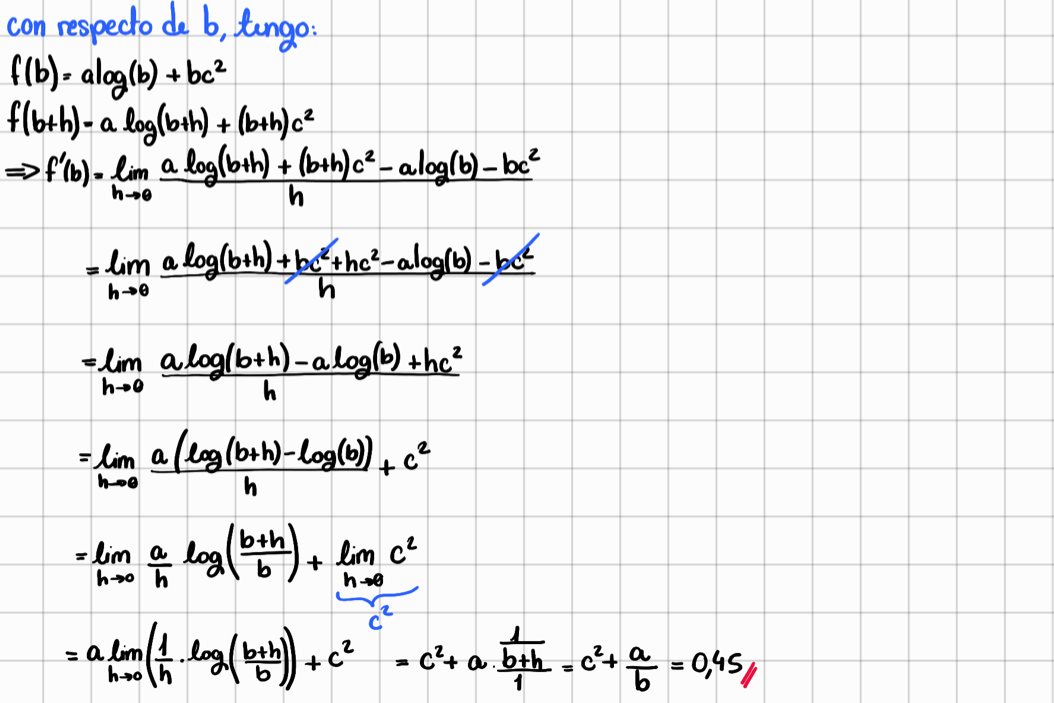

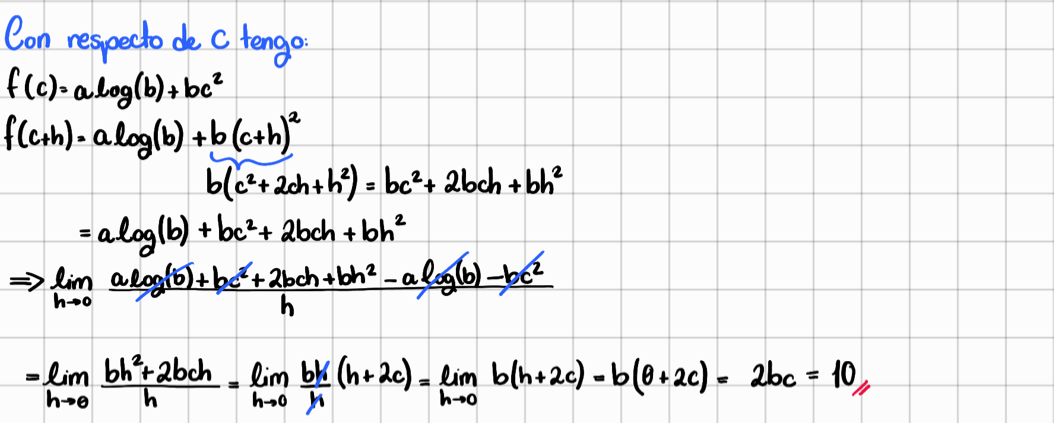

## 3. Utilizando grafos y la regla de la cadena (chain rule differentiation)


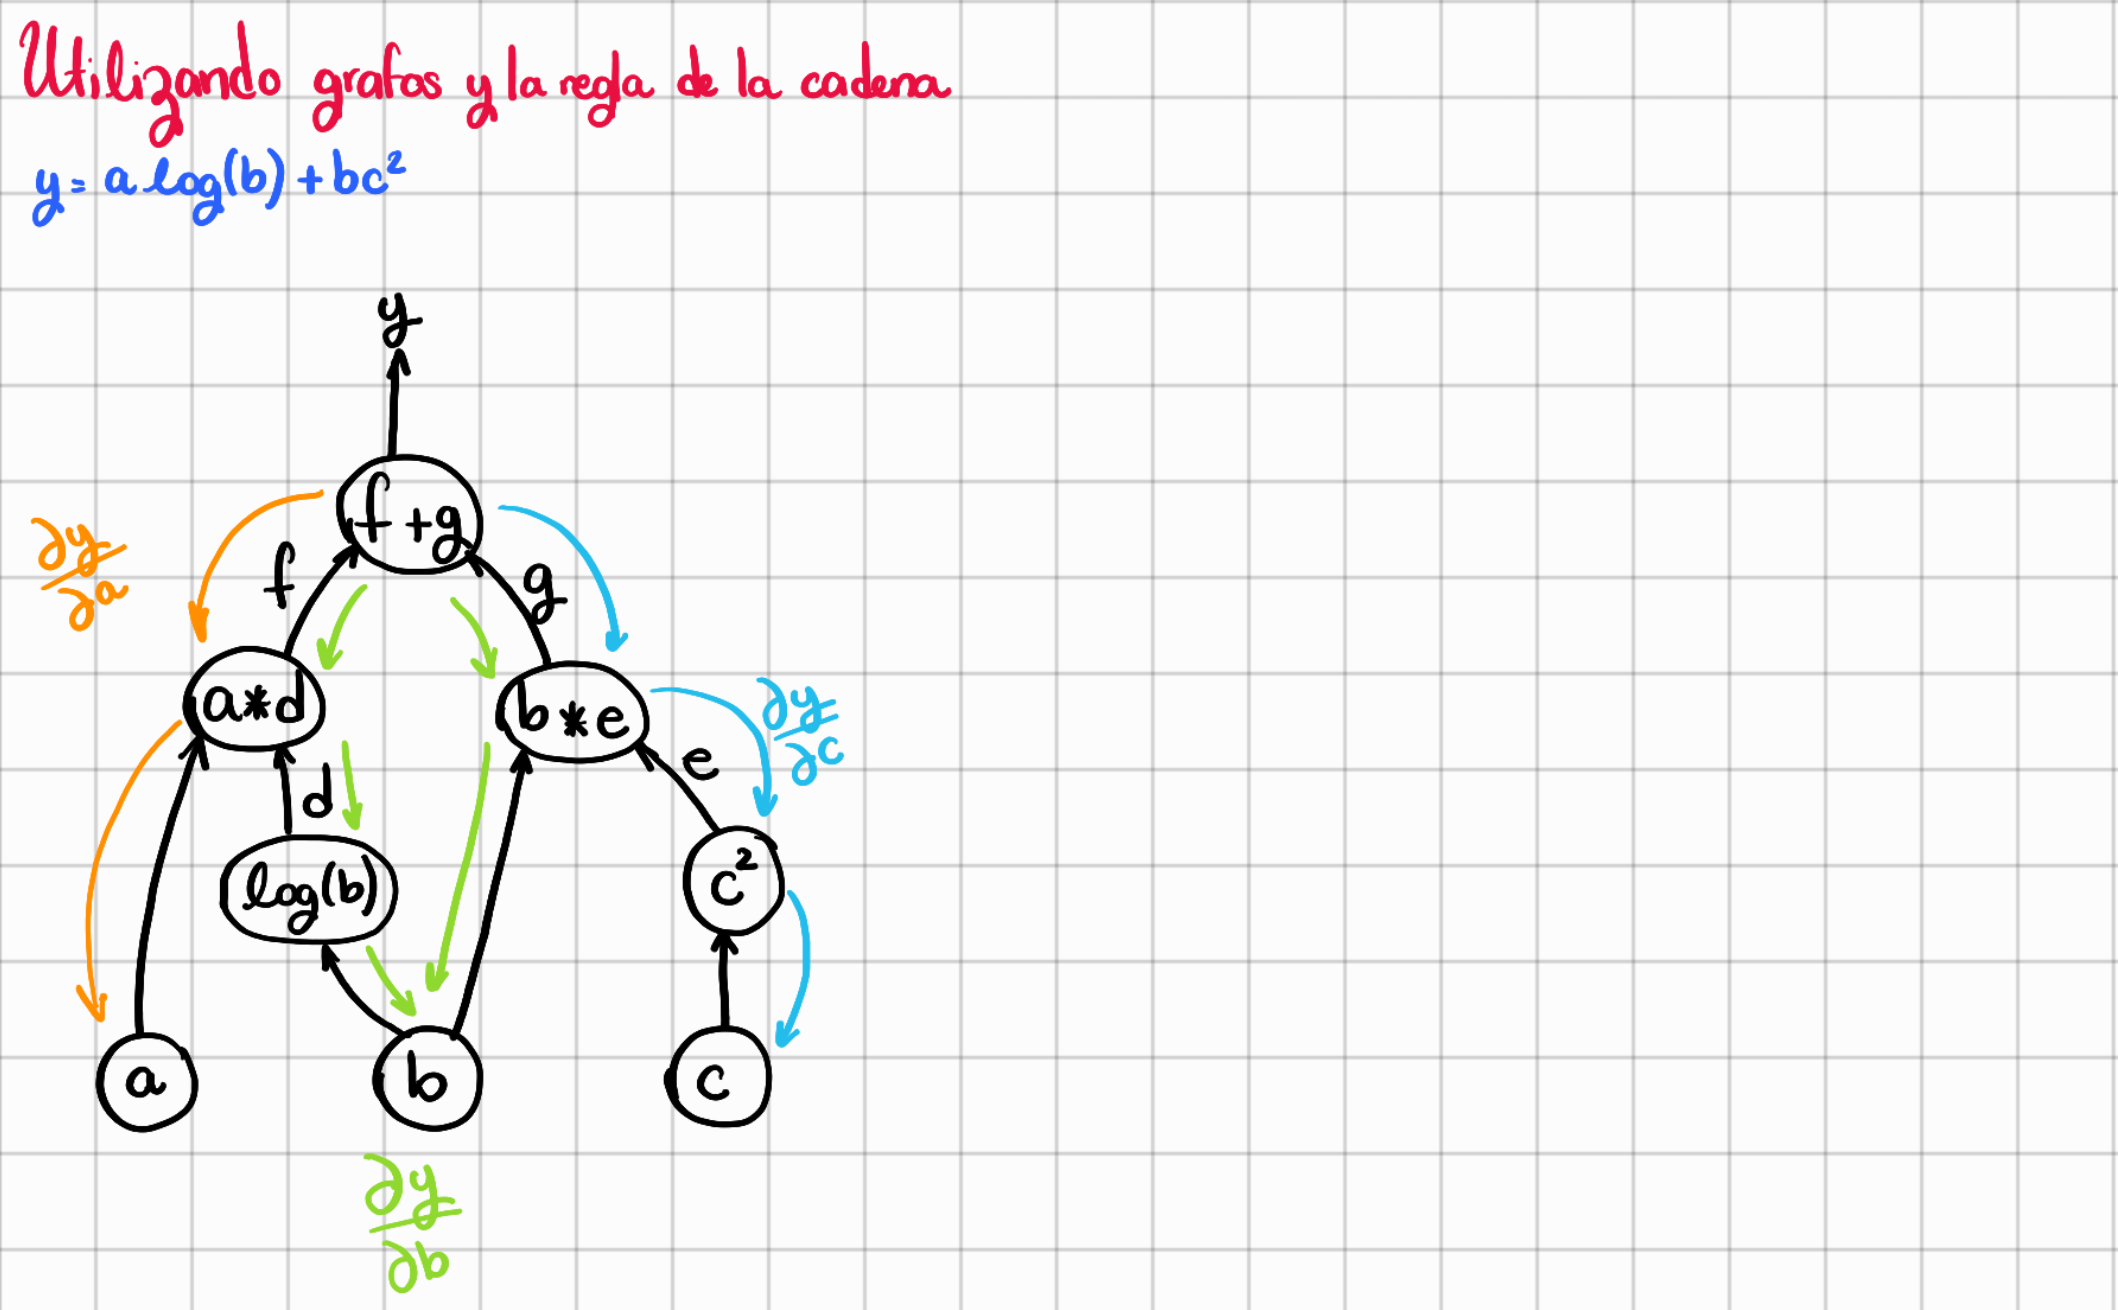

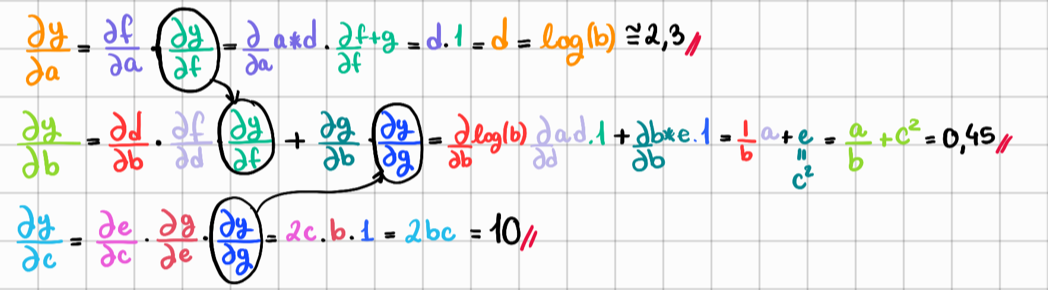

## 4. Utilizando PyTorch (automatic differentiation).

In [ ]:
a = torch.tensor(2., requires_grad=True)
b = torch.tensor(10., requires_grad=True)
c = torch.tensor(0.5, requires_grad=True)

In [ ]:
y = (a * torch.log(b)) + (b * torch.pow(c, 2))

In [ ]:
y.backward()

In [ ]:
print(a.grad)
print(b.grad)
print(c.grad)

tensor(2.3026)
tensor(0.4500)
tensor(10.)
